In [ ]:
# Cell 1
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add src to path so we can import our modules
sys.path.append('../src')
from model import MultiTaskTabNet

# Load test data
test_df = pd.read_parquet('../data/processed/test.parquet')
# For evaluation on known labels, we use a validation split from the train file 
# since the actual 'test.csv' doesn't have public labels.
eval_df = pd.read_parquet('../data/processed/train.parquet').sample(50000, random_state=42)

X_eval = eval_df.drop(['isFraud', 'TransactionID', 'TransactionDT'], axis=1).fillna(-999).astype(np.float32)
y_fraud_true = eval_df['isFraud'].values
y_credit_true = (eval_df['card6'] == 1).astype(int).values # Matching our training proxy

In [ ]:
# Cell 2
device = torch.device('cpu')

# 1. Define the split (Must match CONFIG['SHARED_DIM'] from main.py)
shared_dim = 50
input_dim = shared_dim
private_dim = X_eval.shape[1] - shared_dim

# 2. Initialize with correct dimensions
model = MultiTaskTabNet(input_dim=input_dim, private_dim=private_dim)
model.load_state_dict(torch.load('../outputs/models/unified_mtl_best.pth', map_location=device))
model.eval()

# 3. Get Predictions with Split Inputs
with torch.no_grad():
    # Split the evaluation data just like the training data
    X_tensor = torch.tensor(X_eval.values, dtype=torch.float32)
    x_shared = X_tensor[:, :shared_dim]
    x_private = X_tensor[:, shared_dim:]
    
    # Pass both lanes into the model
    credit_probs, fraud_probs = model(x_shared, x_private)
    
fraud_probs = fraud_probs.numpy().flatten()
credit_probs = credit_probs.numpy().flatten()

print("Inference successful. Calculating new AUC...")

Inference successful. Calculating new AUC...


In [ ]:
# Cell 3
mtl_auc = roc_auc_score(y_fraud_true, fraud_probs)
baseline_auc = 0.8845

print(f"--- Fraud Detection Performance ---")
print(f"Baseline AUC: {baseline_auc}")
print(f"Unified MTL AUC: {mtl_auc:.4f}")
print(f"Improvement: {((mtl_auc - baseline_auc) / baseline_auc)*100:.2f}%")

--- Fraud Detection Performance ---
Baseline AUC: 0.8845
Unified MTL AUC: 0.8309
Improvement: -6.06%


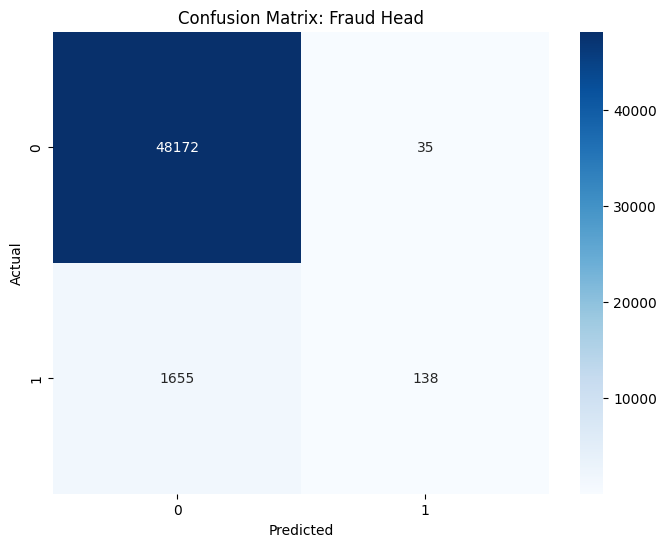

In [ ]:
# Cell 4
cm = confusion_matrix(y_fraud_true, (fraud_probs > 0.5).astype(int))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Fraud Head')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()